In [10]:
"""
use the Lehman rep package for fast fourier transforms
solve the self-consistent equations directly at very low temperatures

A large-N Schwinger boson solver based on a forward fixed-point iteration method.

 The self-energy of bosons and holons are given by,

    Σ_B(τ) = - γ G_c(τ) * G_h(τ),

    Σ_h(τ) = - G_c(β - τ) * G_b(τ),
    
 where the boson and holon Green's function are given by the Dyson equation,

    G_B(iωₙ) = 1/(iνₙ - λ - Σ_B(iνₙ))

    G_h(iωₙ) = 1/(-1/J_K - Σ_h(iνₙ))

 We solve the Dyson equation self-consistently by a weighted fixed point iteration, 
 with weight `mix` assigned to the new iterate and weight `1-mix` assigned to the previous iterate. 
 mix can be rather big for this non-critical system
 
 The self-energy is evaluated in the imaginary time domain, 
 and the Dyson equation is solved in the Matsubara frequency domain.

 one needs to enforce that n_B(λ) = q = 0.3

 You may enforce particle-hole symmetry by setting `symmetry = :ph` when initialize the DLR grids.
 A symmetrized solver tends to be more robust than a unsymmetrized one.
 The is no such symmetry here
"""

using Lehmann
using Printf

diff(a, b) = maximum(abs.(a - b)) # return the maximum deviation between a and b

# Initialize DLR grid

rtol = 1e-8
β = 1000.0
Euv = 100
df = DLRGrid(Euv = Euv, β = β, isFermi = true, rtol = rtol, symmetry = :none) 
db = DLRGrid(Euv = Euv, β = β, isFermi = false, rtol = rtol, symmetry = :none)



tol = -maximum([-df.rtol * 10, -db.rtol * 10])
mix = 0.1
maxiter = 1000
sumrule = nothing
verbose = false
G_B = zeros(ComplexF64, length(db))
G_h = zeros(ComplexF64, length(df))
D = 20
ρ = 1/(2*D)
G_c_matfreq = - ρ .* log.( (D .- df.ωn * 1im) ./ (- D .- df.ωn * 1im))
G_c = matfreq2tau(df, G_c_matfreq)

q0 = 0.5
γ = q0
λ = (1/β) * log(1/q0 +1)
β_K = 30
J_K = 1 / ρ / log(D * β_K)


qerr = 1.0
maxiter = 5000

for iter in 1:maxiter
        
   tau_c = df.τ # DLR imaginary time nodes
   tau_c_rev = df.β .- tau_c # Reversed imaginary time nodes

   G_c_rev = tau2tau(df, G_c, tau_c_rev) # G_c at beta - tau_k

   Sigma_B = - γ .* G_h .* G_c

   Sigma_h = - G_h .* G_c_rev

   Sigma_B_matfreq = tau2matfreq(db, Sigma_B, sumrule = 1)

   Sigma_h_matfreq = tau2matfreq(df, Sigma_h,sumrule = 1)

   G_B_new = 1 ./(db.ωn * 1im .- λ .+ Sigma_B_matfreq)

   G_h_new = 1 ./((- 1 ./J_K ) .+ Sigma_h_matfreq)

   G_B_new_tau = matfreq2tau(db, G_B_new, sumrule = 1)

   G_h_new_tau = matfreq2tau(df, G_h_new, sumrule = 1)

   if verbose
      if iter % (maxiter / 10) == 0
          println("round $iter: change B $(diff(G_B_new, G_B)) change χ $(diff(G_h_new, G_h))")
      end
   end

   if sqrt((diff(G_B_new_tau .- G_B))^2 + (diff(G_B_new_tau .- G_B))^2) < tol && iter > 10
      break
   end

   G_B = mix * G_B_new_tau + (1 - mix) * G_B # Linear mixing

   G_h = mix * G_h_new_tau + (1 - mix) * G_h # Linear mixing

   #solve n_B(λ) = q0
   #func_G_B_new(λp) =  1./(1./G_B_new .+ λ - λp)


end
#######
#tbd - add the lambda loop?
#######

round 500: change 21.31732335603535
round 1000: change 21.31732437939924
round 1500: change 21.317324005639605
round 2000: change 21.3173233821124
round 2500: change 21.3173230639588
round 3000: change 21.31732431869902
round 3500: change 21.317324879469616
round 4000: change 21.317323952906175
round 4500: change 21.31732481388443
round 5000: change 21.31732499688961


In [3]:
cont = 1
jj = 0
while cont==1 
    jj = jj +1
    println("iter: ",jj)
    if jj == 12
        cont = 0
    end
end

iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12


In [ ]:
#####
#figure out measurements
#####

In [1]:
function printG(d, G_x)
    @printf("%15s%40s%40s%40s\n", "τ", "DLR imag", "DLR real", "asymtotically exact")
    for i in 1:d.size
        if d.τ[i] <= d.β / 2
            @printf("%15.8f%40.15f%40.15f%40.15f\n", d.τ[i], imag(G_x[i]), real(G_x[i]), conformal_tau(d.τ[i], d.β))
        end
    end
    println()
end

verbose = false

printstyled("=====    Prepare the expected Green's function of the SYK model     =======\n", color = :yellow)
dsym_correct = DLRGrid(Euv = 5.0, β = 10000.0, isFermi = true, rtol = 1e-14, symmetry = :ph) # Initialize DLR object
G_x_correct = solve_syk_with_fixpoint_iter(dsym_correct, 0.00, mix = 0.1, verbose = false)
#printG(dsym_correct, G_x_correct)

printstyled("=====    Test Symmetrized and Unsymmetrized DLR solver for SYK model     =======\n", color = :yellow)

# @printf("%30s%30s%30s%30s%20s\n", "Euv", "sym_solver", "unsym_solver", "unsym_solver+sum_rule", "good or bad")

rtol = 1e-8
β = 1000.0
Euv = 20
# printstyled("=====     Symmetrized DLR solver for SYK model     =======\n", color = :yellow)
mix = 0.01
dsym = DLRGrid(Euv = Euv, β = β, isFermi = true, rtol = rtol, symmetry = :ph, rebuild = true, verbose = false) # Initialize DLR object
G_x_ph = solve_syk_with_fixpoint_iter(dsym, 0.00, mix = mix, sumrule = nothing, verbose = verbose)

# printstyled("=====     Unsymmetrized DLR solver for SYK model     =======\n", color = :yellow)
mix = 0.01
dnone = DLRGrid(Euv = Euv, β = β, isFermi = true, rtol = rtol, symmetry = :none, rebuild = true, verbose = false) # Initialize DLR object
G_x_none = solve_syk_with_fixpoint_iter(dnone, 0.00 , mix = mix, sumrule = nothing, verbose = verbose)

# printstyled("=====     Unsymmetrized DLR solver for SYK model     =======\n", color = :yellow)
mix = 0.01
G_x_none_sumrule = solve_syk_with_fixpoint_iter(dnone, 0.00, mix = mix, sumrule = 1.0, verbose = verbose)
# printG(dnone, G_x_none)

# printstyled("=====     Unsymmetrized versus Symmetrized DLR solver    =======\n", color = :yellow)
# @printf("%15s%40s%40s%40s\n", "τ", "sym DLR (interpolated)", "unsym DLR", "difference")
# G_x_interp = tau2tau(dsym_correct, G_x_correct, dnone.τ)
# for i in 1:dnone.size
#     if dnone.τ[i] <= dnone.β / 2
#         @printf("%15.8f%40.15f%40.15f%40.15f\n", dnone.τ[i], real(G_x_interp[i]), real(G_x_none[i]), abs(real(G_x_interp[i] - G_x_none[i])))
#     end
# end

G_x_interp_ph = tau2tau(dsym_correct, G_x_correct, dsym.τ)
G_x_interp_none = tau2tau(dsym_correct, G_x_correct, dnone.τ)
G_x_interp_none_sumrule = tau2tau(dsym_correct, G_x_correct, dnone.τ)
d_ph = diff(G_x_interp_ph, G_x_ph)
d_none = diff(G_x_interp_none, G_x_none)
d_none_sumrule = diff(G_x_interp_none_sumrule, G_x_none_sumrule)
flag = (d_ph < 100rtol) && (d_none < 100rtol) && (d_none_sumrule < 100rtol) ? "good" : "bad"

#  @printf("%30.15f%30.15e%30.15e%30.15e%20s\n", Euv, d_ph, d_none, d_none_sumrule, flag)
# println("symmetric Euv = $Euv maximumal difference: ", diff(G_x_interp, G_x_ph))
# println("non symmetric Euv = $Euv maximumal difference: ", diff(G_x_interp, G_x_none))

=====    Prepare the expected Green's function of the SYK model     =======
=====    Test Symmetrized and Unsymmetrized DLR solver for SYK model     =======


"bad"

In [6]:
using Plots

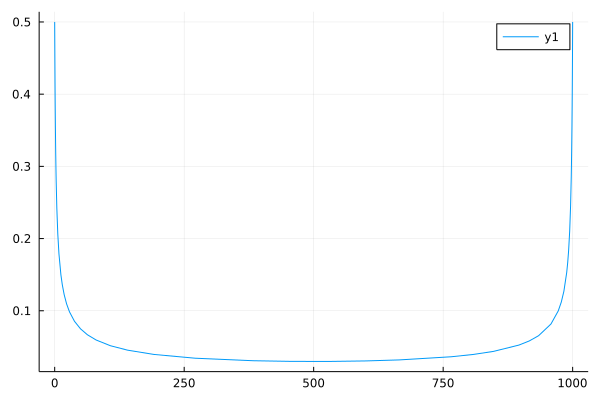

In [8]:
p = plot(dnone.τ, real(G_x_none))
display(p)

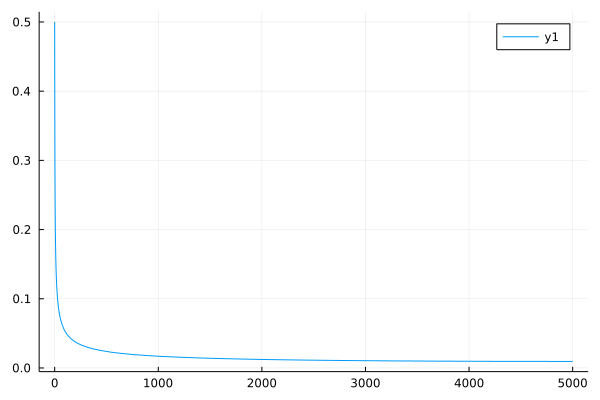

In [12]:
p = plot(dsym_correct.τ, real(G_x_correct))